# Imports

In [ ]:
%load_ext autotime

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from yahoofinancials import YahooFinancials
import numpy as np
import seaborn as sns
import pymongo
pd.options.display.float_format = "{:,.2f}".format
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

time: 691 ms (started: 2021-03-20 15:21:21 -07:00)


# Read Data

We need to pull data from the companies that have storage devices. This includes Western Digital, Seagate, Micron, Samsung, and Intel. Using the Yahoo Finance python library, we can easily pull the stock information using the stock market accronyms. We also need the same timeline for the dataset, and since the stock market dropped because of COVID and the Financial Crisis in 2008, we can pick the data in between the two most significant time periods where stock volatility was extremely high. 

In [3]:
stock_L = {'WDC':'Western Digital', 'STX':'Seagate', 'MU':'Micron', '005930.KS':'Samsung', 'INTC':'Intel', 'TOSYY':'Toshiba', 'KINS':'Kingston'}
time_int_L = ['day', 'week', 'month', 'quarter', 'year']

time: 278 µs (started: 2021-03-20 15:21:22 -07:00)


In [4]:
stock_cols = ['high', 'low', 'open', 'close', 'adjclose', 'volume']

time: 201 µs (started: 2021-03-20 15:21:22 -07:00)


In [5]:
stock_dict = {}
df_time_int = {'day':[], 'week':[], 'month':[], 'quarter':[], 'year':[]}

for stock in stock_L.keys():
    print(stock)
    
    stock_dict[stock] = {} # Define a dictionary for each stock so we can check different time view results.
    
    yahoo_financials = YahooFinancials(stock) # Define the YF Class for the stock of interest
    
    for time_int in time_int_L:
        print('\t', time_int)
        
        if time_int == 'day':
            stock_dict[stock][time_int] = pd.DataFrame(yahoo_financials.get_historical_price_data(start_date='2010-01-01', 
                                                                          end_date='2019-12-31', 
                                                                          time_interval='daily')[stock]['prices']).drop('date', axis=1).rename(columns={'formatted_date':'date'})
            stock_dict[stock][time_int]['day'] = stock_dict[stock][time_int]['date']
            stock_dict[stock]['scaler'] = MinMaxScaler().fit(np.append(stock_dict[stock][time_int]['low'].values, 
                                                                       stock_dict[stock][time_int]['high'].values).reshape(-1, 1))
            
            stock_dict[stock]['scaler_volume'] = MinMaxScaler().fit(stock_dict[stock][time_int]['volume'].values.reshape(-1, 1))
            
            
        elif time_int == 'week': # Pull data as weekly view
            temp =   stock_dict[stock]['day'].copy()
            temp['week'] = ['0'+str(x) if x <10 else str(x) for x in temp['date'].astype(np.datetime64).dt.week]
            temp['week'] = temp['date'].astype(np.datetime64).dt.year.astype(str) + ' W' + temp['week']
            stock_dict[stock][time_int] = temp.groupby(['week']).agg({'high':'max', 'low':'min', 'open':'first', 'close':'last', 'volume':'sum', 'adjclose':'last', 'date':'min'}).reset_index(drop=False)
            
        elif time_int == 'month': # Pull data as monthly view
            temp =   stock_dict[stock]['day'].copy()
            temp['month'] = temp['date'].astype(np.datetime64).astype(str).str[0:7].astype(np.datetime64)
            stock_dict[stock][time_int] = temp.groupby(['month']).agg({'high':'max', 'low':'min', 'open':'first', 'close':'last', 'volume':'sum', 'adjclose':'last'}).reset_index(drop=False)
            stock_dict[stock][time_int]['date'] = stock_dict[stock][time_int]['month']
            
        elif time_int == 'quarter': # Make transformation for quarterly data
            temp =   stock_dict[stock]['day'].copy()
            temp['quarter'] = temp['date'].astype(np.datetime64).dt.year.astype(str) + ' Q' + temp['date'].astype(np.datetime64).dt.quarter.astype(str)
            stock_dict[stock][time_int] = temp.groupby(['quarter']).agg({'high':'max', 'low':'min', 'open':'first', 'close':'last', 'volume':'sum', 'adjclose':'last', 'date':'min'}).reset_index(drop=False)
            
        elif time_int == 'year': # Make transformation for yearly data
            temp =   stock_dict[stock]['day'].copy()
            temp['year'] = temp['date'].astype(np.datetime64).dt.year.astype(str).astype(np.datetime64)
            stock_dict[stock][time_int] = temp.groupby(['year']).agg({'high':'max', 'low':'min', 'open':'first', 'close':'last', 'volume':'sum', 'adjclose':'last'}).reset_index(drop=False)
            stock_dict[stock][time_int]['date'] = stock_dict[stock][time_int]['year']

        # Scale Price Columns
        for col in stock_cols:
            if col =='volume':
                stock_dict[stock][time_int][col+'_scaled'] = stock_dict[stock]['scaler_volume'].transform(stock_dict[stock][time_int][[col]].values)                
            else:
                stock_dict[stock][time_int][col+'_scaled'] = stock_dict[stock]['scaler'].transform(stock_dict[stock][time_int][[col]].values)
        
        
        stock_dict[stock][time_int]['date'] = stock_dict[stock][time_int]['date'].astype(np.datetime64)
        stock_dict[stock][time_int]['stock'] = [stock]*len(stock_dict[stock][time_int])
        stock_dict[stock][time_int]['company'] = stock_dict[stock][time_int]['stock'].apply(lambda x: stock_L[x])
        df_time_int[time_int].append(stock_dict[stock][time_int])
        
for time_int in time_int_L:
    df_time_int[time_int] = pd.concat(df_time_int[time_int])

WDC
	 day
	 week
	 month
	 quarter
	 year
STX
	 day
	 week
	 month
	 quarter
	 year
MU
	 day
	 week
	 month
	 quarter
	 year
005930.KS
	 day
	 week
	 month
	 quarter
	 year
INTC
	 day
	 week
	 month
	 quarter
	 year
TOSYY
	 day
	 week
	 month
	 quarter
	 year
KINS
	 day
	 week
	 month
	 quarter
	 year
time: 6.49 s (started: 2021-03-20 15:21:22 -07:00)


In [6]:
stock_dict['WDC']['day'].head()

,high,low,open,close,volume,adjclose,date,day,high_scaled,low_scaled,open_scaled,close_scaled,adjclose_scaled,volume_scaled,stock,company
0,45.80,44.40,44.40,45.26,3118200,36.33,2010-01-04,2010-01-04,0.25,0.24,0.24,0.25,0.15,0.07,WDC,Western Digital
1,47.44,45.05,45.35,46.46,7048900,37.30,2010-01-05,2010-01-05,0.27,0.24,0.25,0.26,0.16,0.18,WDC,Western Digital
2,46.90,46.05,46.54,46.50,3996100,37.33,2010-01-06,2010-01-06,0.26,0.25,0.26,0.26,0.16,0.09,WDC,Western Digital
3,46.50,45.08,46.40,45.59,3626500,36.60,2010-01-07,2010-01-07,0.26,0.24,0.26,0.25,0.15,0.08,WDC,Western Digital
4,45.84,45.15,45.49,45.82,2521700,36.78,2010-01-08,2010-01-08,0.25,0.24,0.25,0.25,0.15,0.05,WDC,Western Digital


time: 8.87 ms (started: 2021-03-20 15:21:28 -07:00)


## Check Number of Records

In [7]:
num_records = {}
for time_int in time_int_L:
    num_records[time_int] = {}
    for company in stock_dict.keys():
        num_records[time_int][company] = len(stock_dict[company][time_int])
#         print(company, time_int, len(stock_dict[company][time_int]))
    

time: 513 µs (started: 2021-03-20 15:21:28 -07:00)


In [8]:
num_records_df = pd.DataFrame.from_dict(num_records)
num_records_df

,day,week,month,quarter,year
WDC,2515,521,120,40,10
STX,2515,521,120,40,10
MU,2515,521,120,40,10
005930.KS,2465,520,120,40,10
INTC,2515,521,120,40,10
TOSYY,2514,521,120,40,10
KINS,2515,521,120,40,10


time: 3.72 ms (started: 2021-03-20 15:21:28 -07:00)


# Quick Visualization

<AxesSubplot:xlabel='adjclose', ylabel='Density'>

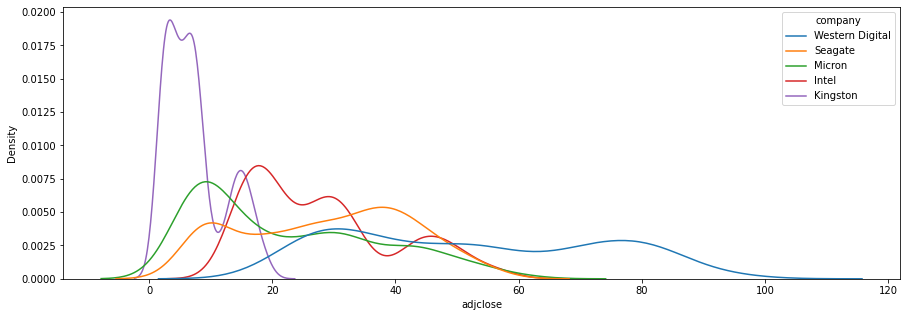

time: 234 ms (started: 2021-03-20 15:21:38 -07:00)


In [10]:
plt.figure(figsize=(15,5))
us_companies = ['MU', 'WDC', 'KINS', 'INTC', 'STX']
sns.kdeplot(data=df_time_int['week'].loc[df_time_int['week']['stock'].isin(us_companies)], x='adjclose', hue='company')

In [11]:
df_time_int['week'].loc[df_time_int['week']['stock'].isin(us_companies)].groupby(['stock']).mean()

,high,low,open,close,volume,adjclose,high_scaled,low_scaled,open_scaled,close_scaled,adjclose_scaled,volume_scaled
stock,,,,,,,,,,,,
INTC,33.29,31.66,32.40,32.53,"178,447,552.78",28.18,0.37,0.33,0.35,0.35,0.25,0.89
KINS,8.82,8.17,8.50,8.49,"98,783.69",7.48,0.34,0.30,0.32,0.32,0.27,0.09
MU,23.49,21.42,22.40,22.51,"154,675,231.67",22.51,0.32,0.29,0.30,0.31,0.31,1.01
STX,39.39,36.51,37.88,38.06,"32,401,769.87",28.94,0.50,0.45,0.48,0.48,0.33,0.36
WDC,62.56,57.97,60.24,60.36,"20,159,499.62",52.17,0.43,0.38,0.41,0.41,0.32,0.53


time: 8.67 ms (started: 2021-03-20 15:21:39 -07:00)


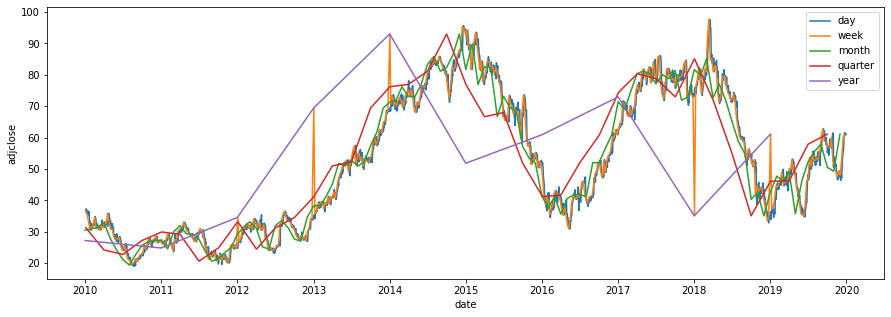

time: 296 ms (started: 2021-03-20 15:21:39 -07:00)


In [12]:
plt.figure(figsize=(15,5))
for key in df_time_int.keys():
    sns.lineplot(data=df_time_int[key].loc[df_time_int[key]['stock']=='WDC'], x='date', y='adjclose', label=key)

<AxesSubplot:title={'center':'Scaled Values'}, xlabel='date', ylabel='adjclose_scaled'>

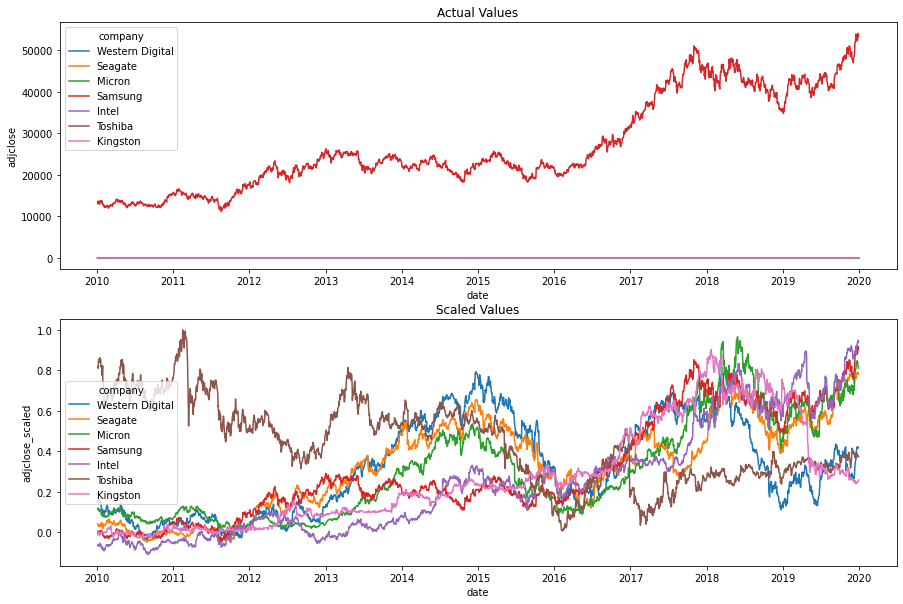

time: 1.25 s (started: 2021-03-20 15:21:39 -07:00)


In [13]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.title('Actual Values')
sns.lineplot(data=df_time_int['day'], x='date', y='adjclose', hue='company')


plt.subplot(2,1,2)
plt.title('Scaled Values')
sns.lineplot(data=df_time_int['day'], x='date', y='adjclose_scaled', hue='company')


# Compare Stocks

In [14]:
df_week = df_time_int['week'].set_index(['week','stock'])['adjclose_scaled'].unstack()
df_week.columns = [stock_L[x] for x in df_week.columns.values]

time: 4 ms (started: 2021-03-20 15:21:41 -07:00)


<AxesSubplot:title={'center':'Week'}, xlabel='date', ylabel='adjclose_scaled'>

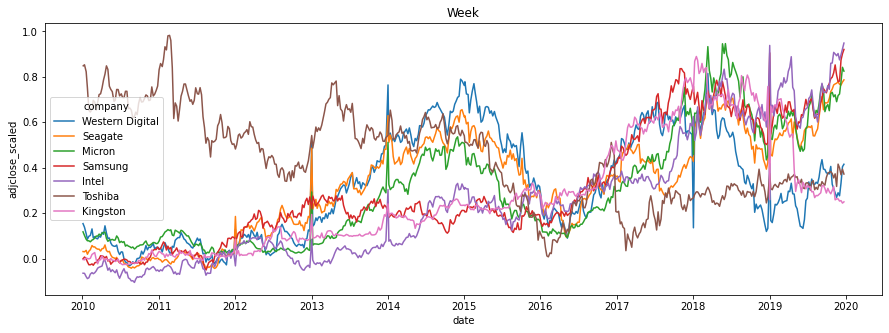

time: 352 ms (started: 2021-03-20 15:21:41 -07:00)


In [15]:
plt.figure(figsize=(15,5))
plt.title('Week')
sns.lineplot(data=df_time_int['week'], x='date', y='adjclose_scaled', hue='company')

<Figure size 1440x1440 with 0 Axes>

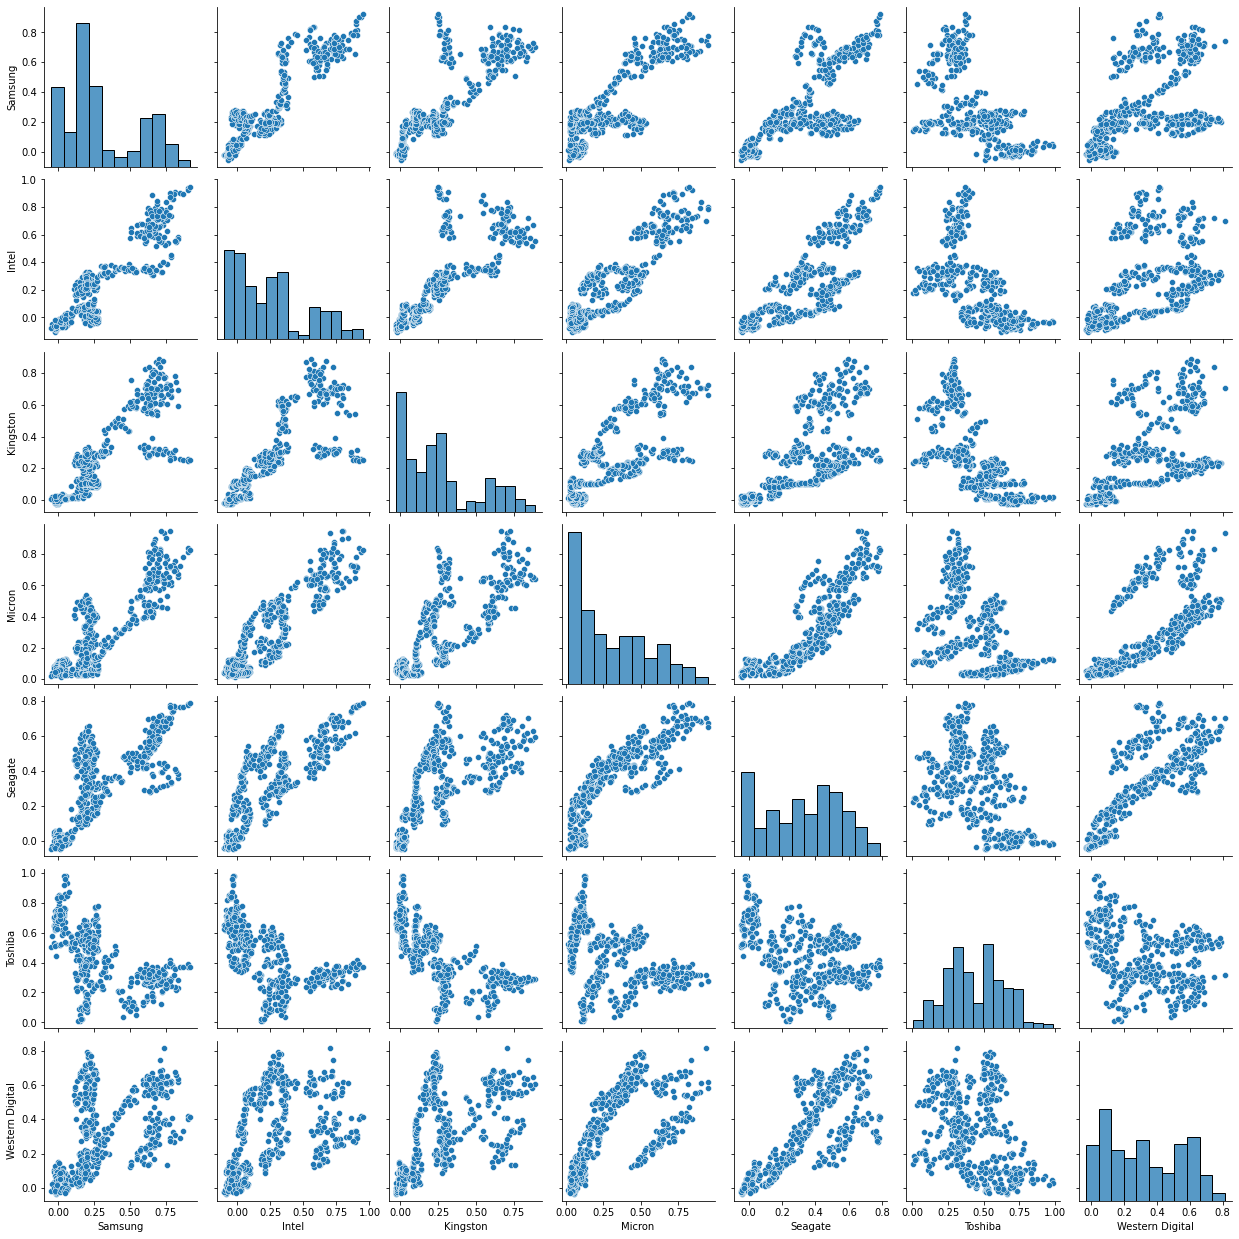

time: 3.51 s (started: 2021-03-20 15:21:41 -07:00)


In [16]:
plt.figure(figsize=(20,20))
sns.pairplot(df_week)

<AxesSubplot:title={'center':'Correlation Per Stock'}>

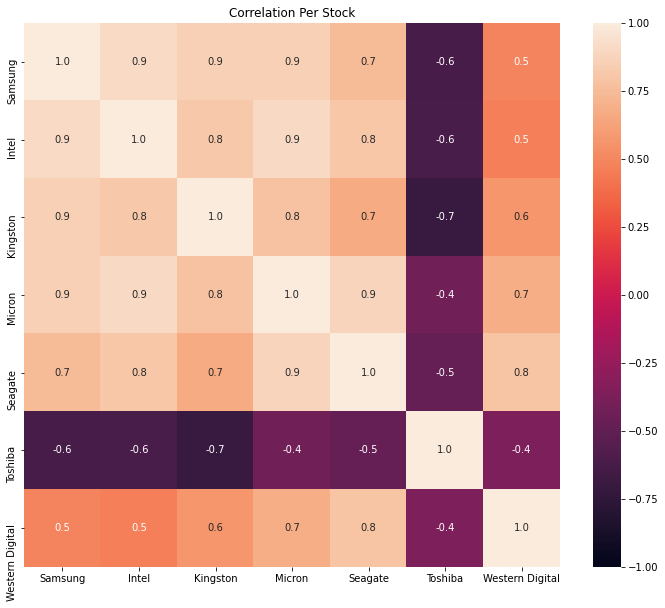

time: 381 ms (started: 2021-03-20 15:21:45 -07:00)


In [17]:
plt.figure(figsize=(12,10))
plt.title('Correlation Per Stock')
sns.heatmap(df_week.corr(), vmin=-1, vmax=1, annot=True, fmt=".1f")

# Get Percent Change

In [18]:
df_time_perc = {}
for key in df_time_int.keys():
    print(key)
    df_time_perc[key] = df_time_int[key].set_index([key,'stock'])['adjclose'].unstack().pct_change().iloc[1:]
    df_time_perc[key] = df_time_int[key].loc[df_time_int[key]['stock']=='WDC'][['date', key]].merge(df_time_perc[key], on=key, how='inner')

day
week
month
quarter
year
time: 29.4 ms (started: 2021-03-20 15:21:45 -07:00)


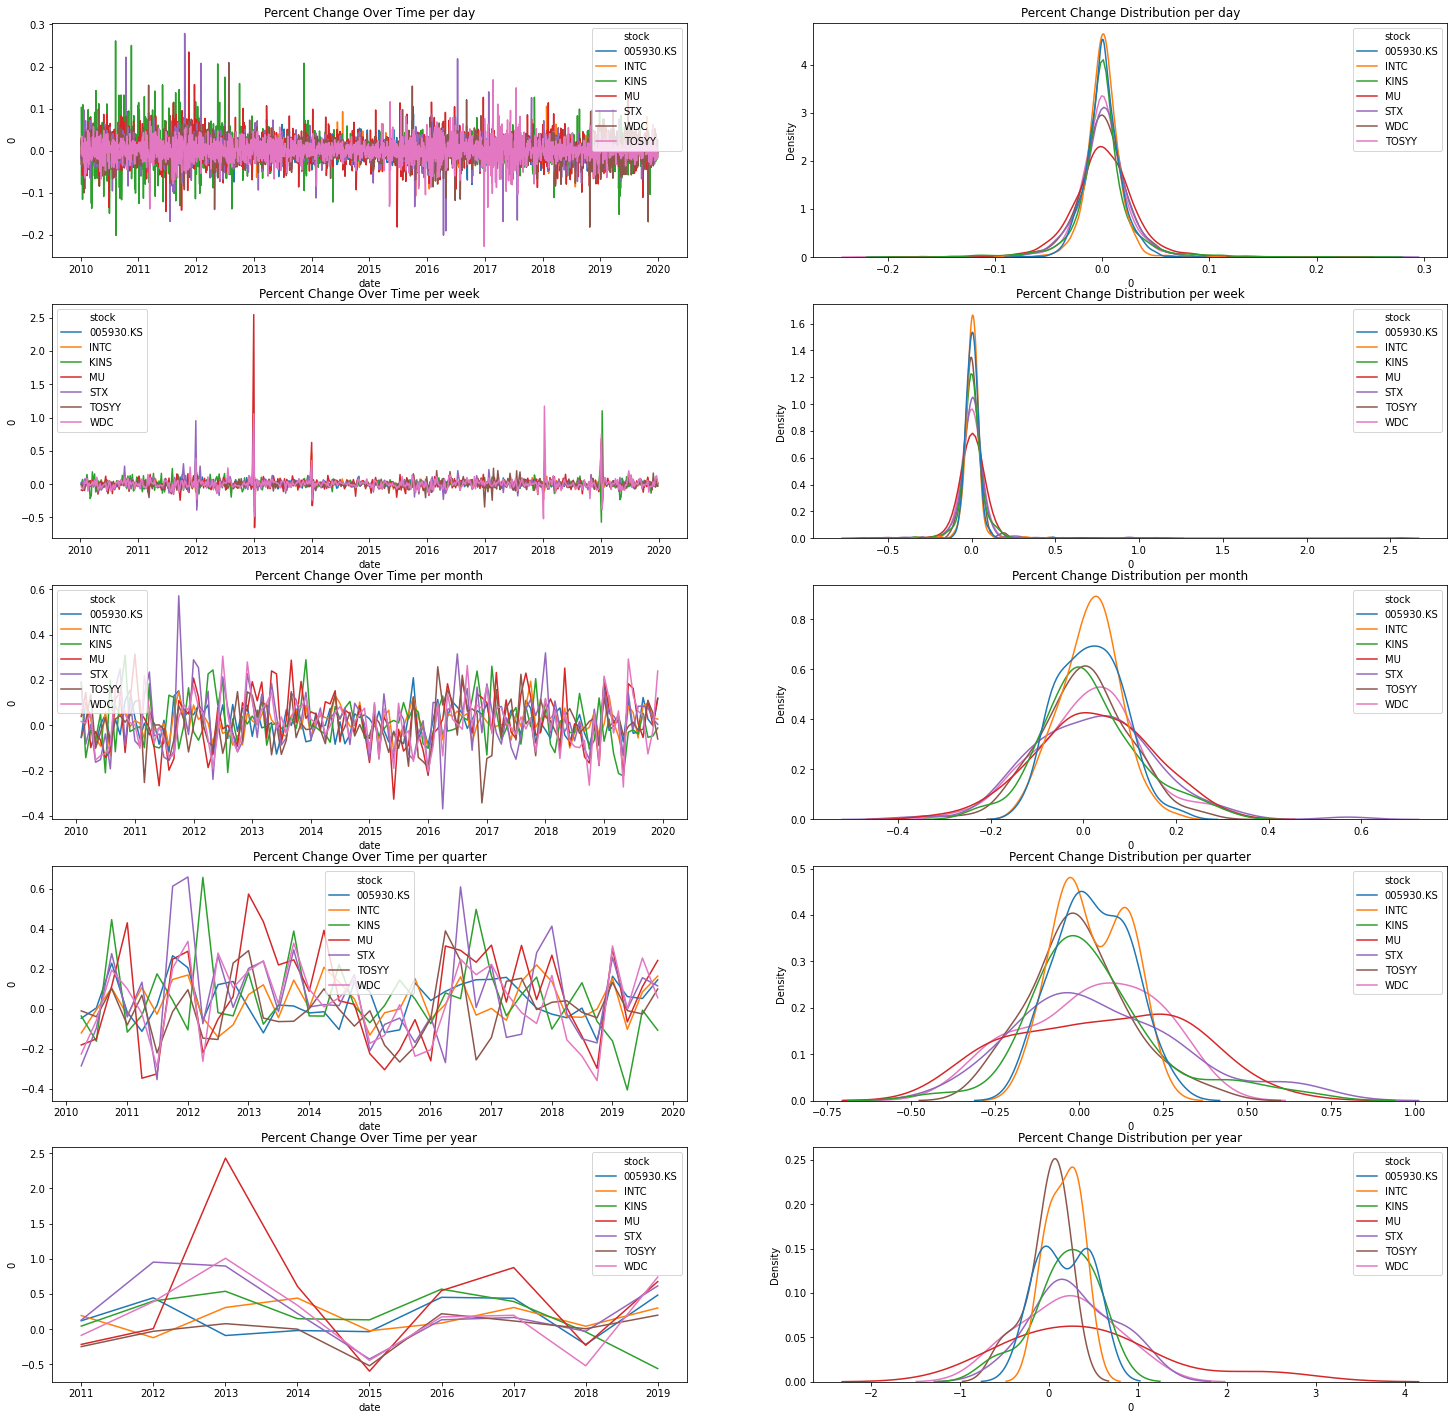

time: 2.33 s (started: 2021-03-20 15:21:45 -07:00)


In [19]:
plt.figure(figsize=(25,25))
for count, time_int in enumerate(time_int_L):
    plt.subplot(5,2,count*2+1)
    plt.title('Percent Change Over Time per '+time_int)
    sns.lineplot(data=df_time_perc[time_int].drop(time_int, axis=1).set_index('date').stack().reset_index(drop=False).rename(columns={'level_1':'stock'}), x='date', y=0, hue='stock')
    
    plt.subplot(5,2,count*2+2)
    plt.title('Percent Change Distribution per '+time_int)
    sns.kdeplot(data=df_time_perc[time_int].drop(time_int, axis=1).set_index('date').stack().reset_index(drop=False).rename(columns={'level_1':'stock'}), x=0, hue='stock')

In [20]:
df_time_perc['week'].describe()

,005930.KS,INTC,KINS,MU,STX,TOSYY,WDC
count,520.00,520.00,520.00,520.00,520.00,520.00,520.00
mean,0.00,0.00,0.01,0.01,0.01,0.00,0.01
std,0.04,0.05,0.09,0.14,0.09,0.05,0.10
min,-0.30,-0.32,-0.57,-0.65,-0.42,-0.34,-0.52
25%,-0.02,-0.02,-0.02,-0.04,-0.03,-0.03,-0.03
50%,0.00,0.00,0.00,0.01,0.01,-0.00,-0.00
75%,0.03,0.02,0.03,0.05,0.04,0.03,0.04
max,0.48,0.46,1.10,2.55,0.95,0.24,1.17


time: 14.9 ms (started: 2021-03-20 15:21:47 -07:00)


In [21]:
df_time_perc['quarter'].describe()

,005930.KS,INTC,KINS,MU,STX,TOSYY,WDC
count,39.00,39.00,39.00,39.00,39.00,39.00,39.00
mean,0.04,0.04,0.05,0.07,0.07,-0.00,0.04
std,0.11,0.10,0.20,0.25,0.24,0.15,0.19
min,-0.16,-0.14,-0.41,-0.35,-0.36,-0.27,-0.36
25%,-0.02,-0.04,-0.07,-0.14,-0.09,-0.07,-0.10
50%,0.02,0.00,0.01,0.06,0.01,-0.01,0.05
75%,0.13,0.14,0.14,0.28,0.23,0.10,0.19
max,0.27,0.22,0.66,0.57,0.66,0.39,0.34


time: 11.9 ms (started: 2021-03-20 15:21:47 -07:00)


# Get Positive or Negative Change

In [22]:
df_time_change = {}
for key in df_time_int.keys():
    print(key)
    df_time_change[key] = df_time_perc[key].copy()
    
    for col in df_time_change[key].columns:
        if col in ['date', key]:
            continue
        df_time_change[key][col] = [1 if x > 0 else -1 if x < 0 else 0 for x in df_time_change[key][col].values]

day
week
month
quarter
year
time: 17.3 ms (started: 2021-03-20 15:21:47 -07:00)


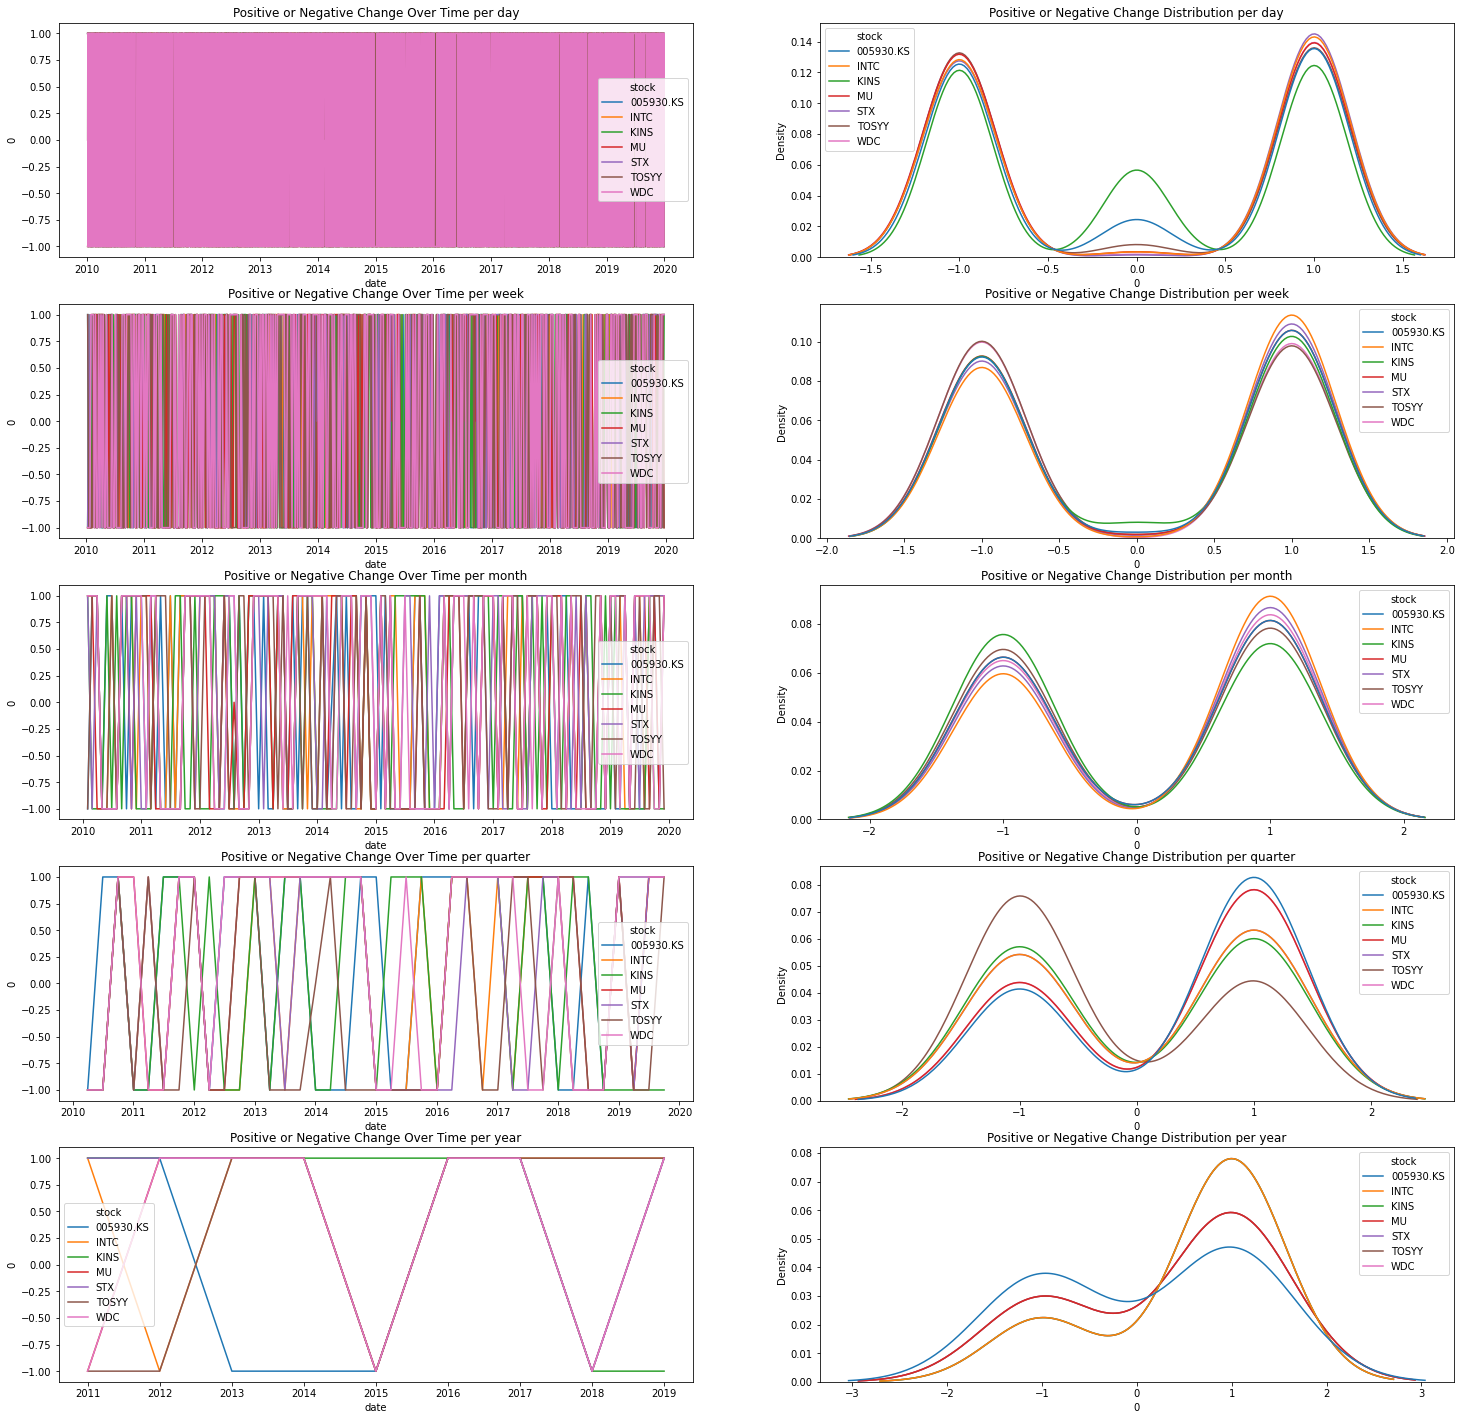

time: 2.65 s (started: 2021-03-20 15:21:47 -07:00)


In [23]:
plt.figure(figsize=(25,25))
for count, time_int in enumerate(time_int_L):
    plt.subplot(5,2,count*2+1)
    plt.title('Positive or Negative Change Over Time per '+time_int)
    sns.lineplot(data=df_time_change[time_int].drop(time_int, axis=1).set_index('date').stack().reset_index(drop=False).rename(columns={'level_1':'stock'}), x='date', y=0, hue='stock')
    
    plt.subplot(5,2,count*2+2)
    plt.title('Positive or Negative Change Distribution per '+time_int)
    sns.kdeplot(data=df_time_change[time_int].drop(time_int, axis=1).set_index('date').stack().reset_index(drop=False).rename(columns={'level_1':'stock'}), x=0, hue='stock')

In [24]:
df_time_change['week'].describe()

,005930.KS,INTC,KINS,MU,STX,TOSYY,WDC
count,520.00,520.00,520.00,520.00,520.00,520.00,520.00
mean,0.07,0.13,0.05,0.07,0.09,-0.01,-0.00
std,0.99,0.99,0.98,0.99,0.99,1.00,1.00
min,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
25%,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
50%,1.00,1.00,1.00,1.00,1.00,-1.00,-1.00
75%,1.00,1.00,1.00,1.00,1.00,1.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00


time: 11.5 ms (started: 2021-03-20 15:21:50 -07:00)


In [25]:
df_time_change['quarter'].describe()

,005930.KS,INTC,KINS,MU,STX,TOSYY,WDC
count,39.00,39.00,39.00,39.00,39.00,39.00,39.00
mean,0.33,0.08,0.03,0.28,0.08,-0.26,0.28
std,0.96,1.01,1.01,0.97,1.01,0.97,0.97
min,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
25%,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
50%,1.00,1.00,1.00,1.00,1.00,-1.00,1.00
75%,1.00,1.00,1.00,1.00,1.00,1.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00


time: 11.2 ms (started: 2021-03-20 15:21:50 -07:00)


# Train ARIMA on 2010 to 2018 data for each Company, then test on every Company and Compare Results

In [26]:
from pandas.plotting import autocorrelation_plot

time: 173 µs (started: 2021-03-20 15:21:50 -07:00)


In [27]:
stock_L

{'WDC': 'Western Digital',
 'STX': 'Seagate',
 'MU': 'Micron',
 '005930.KS': 'Samsung',
 'INTC': 'Intel',
 'TOSYY': 'Toshiba',
 'KINS': 'Kingston'}

time: 895 µs (started: 2021-03-20 15:21:50 -07:00)


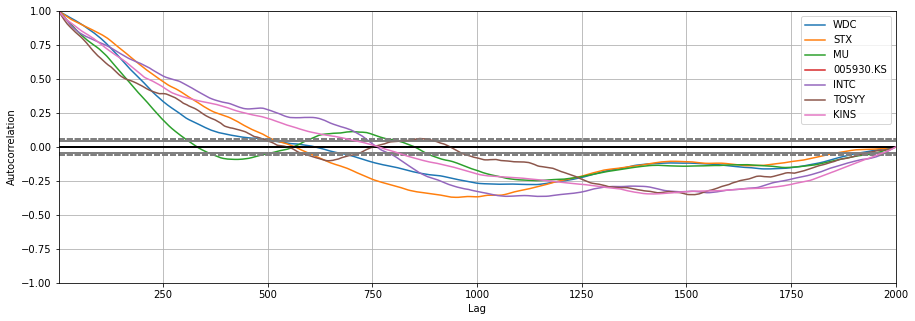

time: 324 ms (started: 2021-03-20 15:21:50 -07:00)


In [28]:
plt.figure(figsize=(15,5))
for stock in stock_L.keys():
    autocorrelation_plot(df_time_int['day'].loc[df_time_int['day']['stock']==stock]['adjclose_scaled'].head(2000), label=stock)
#     break
plt.legend()
# plt.ylim(-.25, .25)

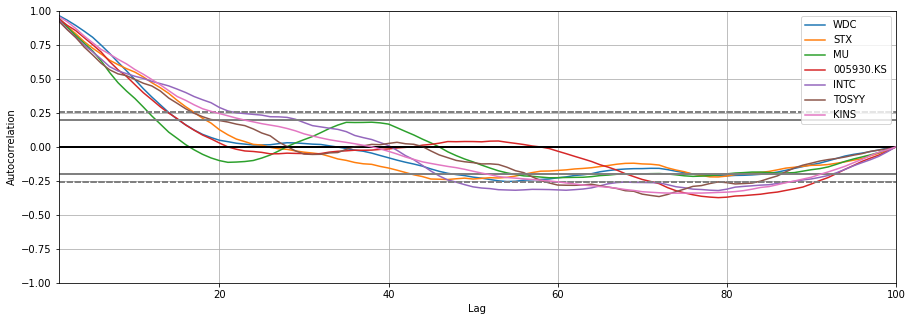

time: 255 ms (started: 2021-03-20 15:21:50 -07:00)


In [29]:
plt.figure(figsize=(15,5))
for stock in stock_L.keys():
    autocorrelation_plot(df_time_int['month'].loc[df_time_int['month']['stock']==stock]['adjclose_scaled'].head(100), label=stock)
#     break
plt.legend()
# plt.ylim(-.25, .25)

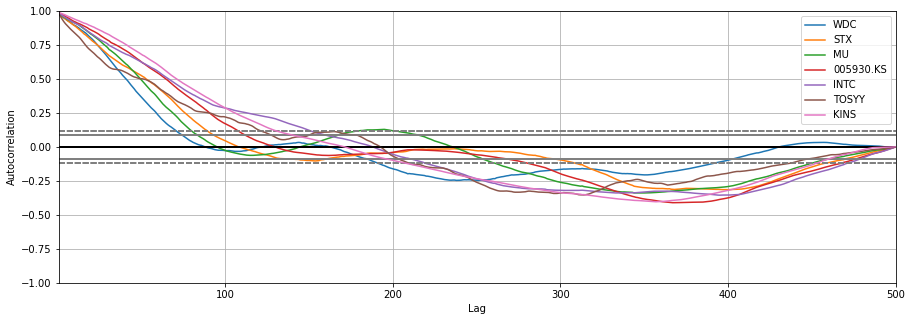

time: 214 ms (started: 2021-03-20 15:21:51 -07:00)


In [30]:
plt.figure(figsize=(15,5))
for stock in stock_L.keys():
    autocorrelation_plot(df_time_int['week'].loc[df_time_int['week']['stock']==stock]['adjclose_scaled'].head(500), label=stock)
#     break
plt.legend()
# plt.ylim(-.25, .25)

(-0.25, 0.25)

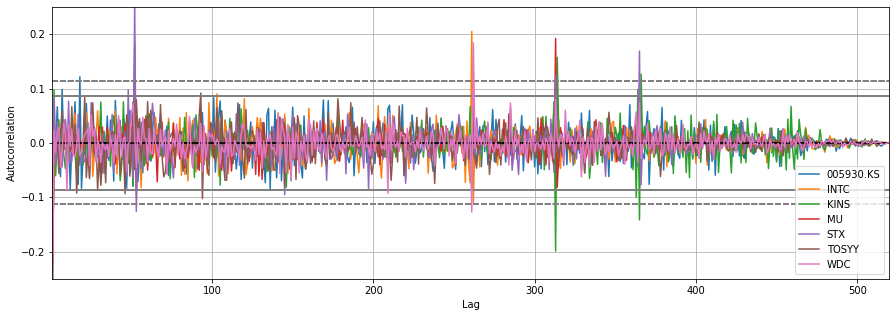

time: 357 ms (started: 2021-03-20 15:21:51 -07:00)


In [31]:
plt.figure(figsize=(15,5))
for col in df_time_perc['week'].columns:
    if col in ['date', 'week']:
        continue
    autocorrelation_plot(df_time_perc['week'][col], label=col)
plt.legend()
plt.ylim(-.25, .25)

/Users/emilioramos/opt/anaconda3/envs/ist652/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    WDC   No. Observations:                  520
Model:               ARIMA(40, 1, 10)   Log Likelihood                 462.868
Date:                Sat, 20 Mar 2021   AIC                           -823.736
Time:                        15:22:29   BIC                           -606.889
Sample:                             0   HQIC                          -738.782
                                - 520                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2379      6.094     -0.203      0.839     -13.183      10.707
ar.L2         -1.0807      4.970     -0.217      0.828     -10.822       8.661
ar.L3         -1.0920      5.763     -0.189      0.8

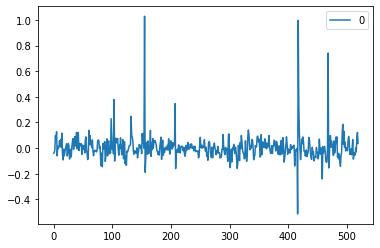

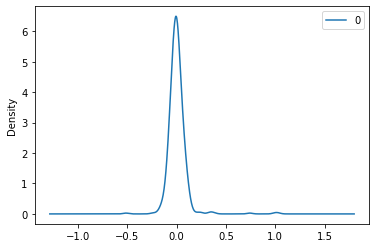

           0
count 520.00
mean    0.00
std     0.10
min    -0.51
25%    -0.04
50%    -0.00
75%     0.04
max     1.03
time: 37.9 s (started: 2021-03-20 15:21:51 -07:00)


In [32]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
# fit model
model = ARIMA(df_time_perc['week']['WDC'], order=(40,1,10))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

# Time Series Regression Using SKLearn

In [33]:
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics
from sklearn import linear_model, neural_network, neighbors, ensemble, svm
from sklearn.model_selection import cross_val_score
import math

time: 72.8 ms (started: 2021-03-20 15:22:29 -07:00)


## Create Metric For Regressions

In [34]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

time: 1.13 ms (started: 2021-03-20 15:22:29 -07:00)


## By Week

### Create Training Dataset

In [35]:
model_time_int = 'week'

time: 195 µs (started: 2021-03-20 15:22:29 -07:00)


In [36]:
df_model_data = df_time_int[model_time_int].set_index([model_time_int,'stock'])[['adjclose_scaled', 'volume_scaled']].unstack().swaplevel(i=1, j=0, axis=1)

for stock in stock_L.keys():
    
    df_model_data[(stock, 'adjclose_perc_change')] = df_model_data[(stock, 'adjclose_scaled')].pct_change()
    df_model_data[(stock, 'adjclose_lag1')] = df_model_data[(stock, 'adjclose_scaled')].shift()   

    df_model_data[(stock, 'adjclose_perc_change_lag1')] = df_model_data[(stock, 'adjclose_perc_change')].shift()   
    
    df_model_data[(stock, 'volume_lag1')] = df_model_data[(stock, 'volume_scaled')].shift()
    df_model_data[(stock, 'volume_change_lag1')] = df_model_data[(stock, 'volume_lag1')].diff()
    
df_model_data = df_model_data.dropna()

time: 21.4 ms (started: 2021-03-20 15:22:29 -07:00)


In [37]:
model_data = {}

x_cols = ['adjclose_perc_change_lag1','adjclose_lag1', 'volume_change_lag1', 'volume_lag1']
y_col = ['adjclose_scaled']

# Get 80% of dates as train
date_time_split = math.floor(len(df_model_data)*.8)

for stock in stock_L.keys():
    model_data[stock] = {}    
    
    # Get Training Data
    model_data[stock]['train_x'] = df_model_data[stock][:date_time_split][x_cols]
    model_data[stock]['train_y'] = df_model_data[stock][:date_time_split][y_col]
    
    # Get Testing Data
    model_data[stock]['test_x'] = df_model_data[stock][date_time_split:][x_cols]
    model_data[stock]['test_y'] = df_model_data[stock][date_time_split:][y_col]


time: 12.6 ms (started: 2021-03-20 15:22:29 -07:00)


In [38]:
print('Train X: ', model_data[stock]['train_x'].shape)
print('Train y: ', model_data[stock]['train_y'].shape)
print('Test  X: ', model_data[stock]['test_x'].shape)
print('Test  y: ', model_data[stock]['test_y'].shape)

Train X:  (412, 4)
Train y:  (412, 1)
Test  X:  (104, 4)
Test  y:  (104, 1)
time: 485 µs (started: 2021-03-20 15:22:29 -07:00)


### Create a List of Different Models and Train Them

In [39]:
stock_model = {}
for stock in stock_L.keys():
    
    stock_model[stock] = {}
    stock_model[stock]['models'] = []
    stock_model[stock]['models'].append(('LR', linear_model.LinearRegression()))
    stock_model[stock]['models'].append(('NN', neural_network.MLPRegressor(solver = 'lbfgs')))  #neural network
    stock_model[stock]['models'].append(('KNN', neighbors.KNeighborsRegressor())) 
    stock_model[stock]['models'].append(('RF', ensemble.RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
    stock_model[stock]['models'].append(('SVR', svm.SVR(gamma='auto'))) # kernel = linear
    # Evaluate each model in turn
    stock_model[stock]['results'] = []
    stock_model[stock]['names'] = []
    
    for name, model in stock_model[stock]['models']:
        # TimeSeries Cross validation
        tscv = TimeSeriesSplit(n_splits=10)

        cv_results = cross_val_score(model, model_data[stock]['train_x'], model_data[stock]['train_y'], cv=tscv, scoring='r2')
        stock_model[stock]['results'].append(cv_results)
        stock_model[stock]['names'].append(name)
        print('stock: %s model: %s: %f (%f)' % (stock, name, cv_results.mean(), cv_results.std()))
        
        


stock: WDC model: LR: 0.539612 (0.349619)
stock: WDC model: NN: 0.472062 (0.315586)
stock: WDC model: KNN: -1.871474 (2.449075)
stock: WDC model: RF: -0.727838 (2.011722)
stock: WDC model: SVR: -1.208780 (2.078472)
stock: STX model: LR: 0.607412 (0.314582)
stock: STX model: NN: -0.062537 (2.010646)
stock: STX model: KNN: -1.742166 (2.529290)
stock: STX model: RF: -0.409296 (1.456410)
stock: STX model: SVR: -1.904243 (3.104551)
stock: MU model: LR: 0.560024 (0.380706)
stock: MU model: NN: -0.457683 (2.728464)
stock: MU model: KNN: -6.507542 (9.059072)
stock: MU model: RF: -0.856068 (2.661673)
stock: MU model: SVR: -6.060445 (8.700842)
stock: 005930.KS model: LR: 0.664695 (0.288141)
stock: 005930.KS model: NN: -0.246048 (2.849981)
stock: 005930.KS model: KNN: -3.185968 (3.057619)
stock: 005930.KS model: RF: -0.545471 (1.503248)
stock: 005930.KS model: SVR: -3.392789 (2.546735)
stock: INTC model: LR: 0.495836 (0.367414)
stock: INTC model: NN: -2.454533 (7.408546)
stock: INTC model: KNN: -

### Compare Models

In [40]:
res = {}
for stock in stock_model.keys():
    res[stock]={}
    for name, res1 in zip(stock_model[stock]['names'], stock_model[stock]['results']):
        res[stock][name] = res1.mean()
res = pd.DataFrame.from_dict(res, orient='index')

time: 924 µs (started: 2021-03-20 15:22:33 -07:00)


<AxesSubplot:title={'center':'Modeling Results'}>

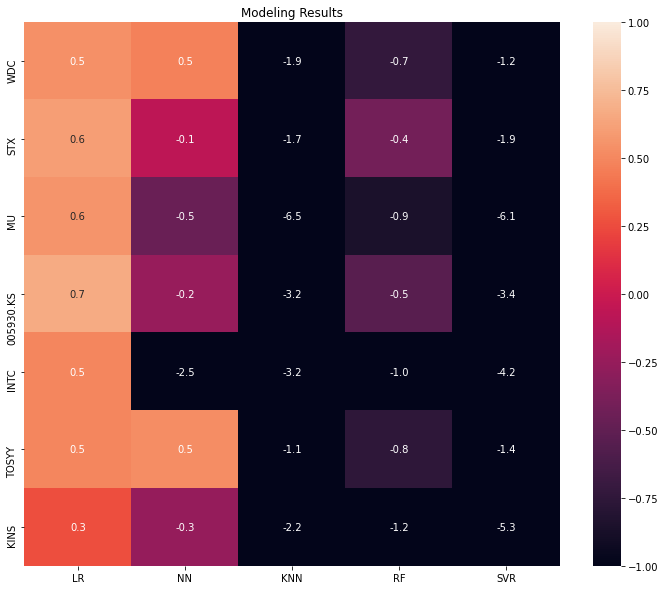

time: 252 ms (started: 2021-03-20 15:22:33 -07:00)


In [41]:
plt.figure(figsize=(12,10))
plt.title('Modeling Results')
sns.heatmap(res, vmin=-1, vmax=1, annot=True, fmt=".1f")

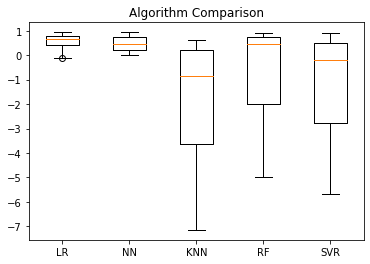

time: 88.2 ms (started: 2021-03-20 15:22:34 -07:00)


In [42]:
# Compare Algorithms
plt.boxplot(stock_model['WDC']['results'], labels=stock_model['WDC']['names'])
# plt.ylim(-100, 1)
plt.title('Algorithm Comparison')
plt.show()

## By Month

### Create Training Dataset

In [43]:
model_time_int = 'month'

time: 189 µs (started: 2021-03-20 15:22:34 -07:00)


In [44]:
df_model_data = df_time_int[model_time_int].set_index([model_time_int,'stock'])[['adjclose_scaled', 'volume_scaled']].unstack().swaplevel(i=1, j=0, axis=1)

for stock in stock_L.keys():
    
    df_model_data[(stock, 'adjclose_perc_change')] = df_model_data[(stock, 'adjclose_scaled')].pct_change()
    df_model_data[(stock, 'adjclose_lag1')] = df_model_data[(stock, 'adjclose_scaled')].shift()   

    df_model_data[(stock, 'adjclose_perc_change_lag1')] = df_model_data[(stock, 'adjclose_perc_change')].shift()   
    
    df_model_data[(stock, 'volume_lag1')] = df_model_data[(stock, 'volume_scaled')].shift()
    df_model_data[(stock, 'volume_change_lag1')] = df_model_data[(stock, 'volume_lag1')].diff()
    
df_model_data = df_model_data.dropna()

time: 20.9 ms (started: 2021-03-20 15:22:34 -07:00)


In [45]:
model_data = {}

x_cols = ['adjclose_perc_change_lag1','adjclose_lag1', 'volume_change_lag1', 'volume_lag1']
y_col = ['adjclose_scaled']

# Get 80% of dates as train
date_time_split = math.floor(len(df_model_data)*.8)

for stock in stock_L.keys():
    model_data[stock] = {}    
    
    # Get Training Data
    model_data[stock]['train_x'] = df_model_data[stock][:date_time_split][x_cols]
    model_data[stock]['train_y'] = df_model_data[stock][:date_time_split][y_col]
    
    # Get Testing Data
    model_data[stock]['test_x'] = df_model_data[stock][date_time_split:][x_cols]
    model_data[stock]['test_y'] = df_model_data[stock][date_time_split:][y_col]


time: 14.9 ms (started: 2021-03-20 15:22:34 -07:00)


In [46]:
model_data[stock]['train_x'].tail()

,adjclose_perc_change_lag1,adjclose_lag1,volume_change_lag1,volume_lag1
month,,,,
2017-08-01,0.09,0.65,-1.04,0.81
2017-09-01,-0.10,0.59,0.28,1.09
2017-10-01,0.10,0.65,-0.13,0.97
2017-11-01,-0.01,0.64,-0.37,0.60
2017-12-01,0.24,0.80,0.02,0.62


time: 3.82 ms (started: 2021-03-20 15:22:34 -07:00)


In [47]:
print('Train X: ', model_data[stock]['train_x'].shape)
print('Train y: ', model_data[stock]['train_y'].shape)
print('Test  X: ', model_data[stock]['test_x'].shape)
print('Test  y: ', model_data[stock]['test_y'].shape)

Train X:  (94, 4)
Train y:  (94, 1)
Test  X:  (24, 4)
Test  y:  (24, 1)
time: 431 µs (started: 2021-03-20 15:22:34 -07:00)


### Create a List of Different Models and Train Them

In [48]:
stock_model = {}
for stock in stock_L.keys():
    
    stock_model[stock] = {}
    stock_model[stock]['models'] = []
    stock_model[stock]['models'].append(('LR', linear_model.LinearRegression()))
    stock_model[stock]['models'].append(('NN', neural_network.MLPRegressor(solver = 'lbfgs')))  #neural network
    stock_model[stock]['models'].append(('KNN', neighbors.KNeighborsRegressor())) 
    stock_model[stock]['models'].append(('RF', ensemble.RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
    stock_model[stock]['models'].append(('SVR', svm.SVR(gamma='auto'))) # kernel = linear
    # Evaluate each model in turn
    stock_model[stock]['results'] = []
    stock_model[stock]['names'] = []
    
    for name, model in stock_model[stock]['models']:
        # TimeSeries Cross validation
        tscv = TimeSeriesSplit(n_splits=10)

        cv_results = cross_val_score(model, model_data[stock]['train_x'], model_data[stock]['train_y'], cv=tscv, scoring='r2')
        stock_model[stock]['results'].append(cv_results)
        stock_model[stock]['names'].append(name)
        print('stock: %s model: %s: %f (%f)' % (stock, name, cv_results.mean(), cv_results.std()))


stock: WDC model: LR: -0.669622 (2.130519)
stock: WDC model: NN: -1.495663 (2.244709)
stock: WDC model: KNN: -11.112380 (12.794565)
stock: WDC model: RF: -1.785750 (2.444223)
stock: WDC model: SVR: -5.457297 (5.284114)
stock: STX model: LR: -0.183148 (0.847197)
stock: STX model: NN: -1.412713 (3.156311)
stock: STX model: KNN: -4.450334 (4.111744)
stock: STX model: RF: -2.071205 (2.672765)
stock: STX model: SVR: -4.097991 (4.492576)
stock: MU model: LR: 0.361774 (0.308702)
stock: MU model: NN: -0.369125 (1.500463)
stock: MU model: KNN: -9.549759 (12.528125)
stock: MU model: RF: -1.078453 (2.229145)
stock: MU model: SVR: -4.259032 (5.499937)
stock: 005930.KS model: LR: -0.551149 (1.793534)
stock: 005930.KS model: NN: -3.138585 (8.483167)
stock: 005930.KS model: KNN: -10.455327 (13.411637)
stock: 005930.KS model: RF: -2.501524 (3.206466)
stock: 005930.KS model: SVR: -7.130675 (7.325641)
stock: INTC model: LR: -0.491248 (1.245293)
stock: INTC model: NN: -404.658834 (1192.319097)
stock: INT

### Compare Models

In [50]:
res = {}
for stock in stock_model.keys():
    res[stock]={}
    for name, res1 in zip(stock_model[stock]['names'], stock_model[stock]['results']):
        res[stock][name] = res1.mean()
res = pd.DataFrame.from_dict(res, orient='index')

time: 5.53 ms (started: 2021-03-20 15:23:23 -07:00)


<AxesSubplot:title={'center':'Modeling Results'}>

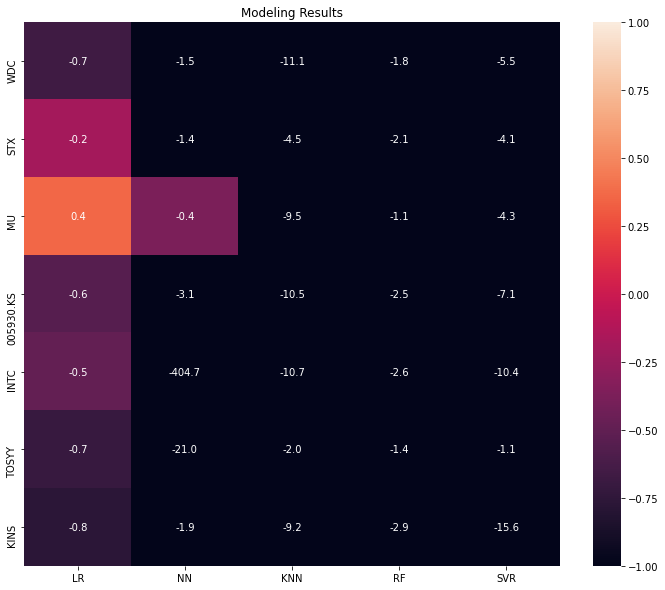

time: 270 ms (started: 2021-03-20 15:23:23 -07:00)


In [51]:
plt.figure(figsize=(12,10))
plt.title('Modeling Results')
sns.heatmap(res, vmin=-1, vmax=1, annot=True, fmt=".1f")

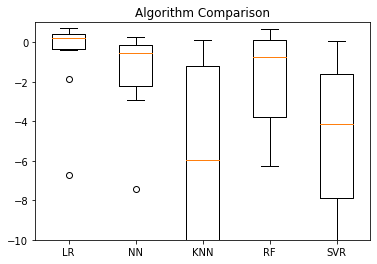

time: 81.5 ms (started: 2021-03-20 15:22:37 -07:00)


In [49]:
# Compare Algorithms
plt.boxplot(stock_model['WDC']['results'], labels=stock_model['WDC']['names'])
plt.ylim(-10, 1)
plt.title('Algorithm Comparison')
plt.show()